---
title: Lab 4
jupyter: python3
format:
    html:
        embed-resources: true
---

In [233]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
Key = "0dc394df91msh65f4716a86731a3p12f799jsn64382f922daf"
HEADERS = {"User-Agent": "Mozilla/5.0"}


# Task 1

In [234]:
URL = "https://tastesbetterfromscratch.com/meal-plan-208/"


response = requests.get(URL, headers=HEADERS)
soup = BeautifulSoup(response.content, "html.parser")

text = soup.get_text(" ", strip=True)
pattern = r"(Monday|Tuesday|Wednesday|Thursday|Friday)\s*[:\-–]?\s*(.*?)\s*\$([\d,]+(?:\.\d{2})?)" ###(chatgpt help)
matches = re.findall(pattern, text, re.I)

df = pd.DataFrame(matches, columns=["Day of the Week", "Name of Recipe", "Price of Recipe"])
df["Price of Recipe"] = df["Price of Recipe"].str.replace(",", "").astype(float)

# get links
def get_link(name):
    tag = soup.find("a", string=re.compile(re.escape(name), re.I))
    return tag["href"] if tag else None

df["Link to Recipe"] = df["Name of Recipe"].apply(get_link)
df

,Day of the Week,Name of Recipe,Price of Recipe,Link to Recipe
0,Monday,Lemon Chicken Pasta,16.0,https://tastesbetterfromscratch.com/lemon-parm...
1,Tuesday,Lomo Saltado,28.0,https://tastesbetterfromscratch.com/lomo-saltado/
2,Wednesday,Burrata Pizza,20.0,https://tastesbetterfromscratch.com/burrata-pi...
3,Thursday,Salmon Bowls,25.0,https://tastesbetterfromscratch.com/salmon-bowls/
4,Friday,BBQ Pulled Pork Sandwiches,25.0,https://tastesbetterfromscratch.com/bbq-pulled...


# Task 2

In [235]:
###(chatgpt debug help)
monday_recipe = df.loc[df["Day of the Week"] == "Monday", "Name of Recipe"].iloc[0]
query = re.sub(r"[^A-Za-z0-9 ]+", " ", monday_recipe).strip()

url = "https://tasty.p.rapidapi.com/recipes/list"
params = {"from": "0", "size": "100", "q": query}

headers = {
    "x-rapidapi-key": "0dc394df91msh65f4716a86731a3p12f799jsn64382f922daf",
    "x-rapidapi-host": "tasty.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=params)
data = response.json()

if "results" in data:
    results = pd.json_normalize(data["results"])
    print("Recipes found:", len(results))
    results.head()
else:
    print(data)

if "results" in data and len(data["results"]) > 0:
    tbl = pd.json_normalize(data["results"])
    keep = [
        "name", "id", "num_servings", "total_time_minutes",
        "nutrition.calories", "nutrition.fat", "nutrition.protein",
        "nutrition.carbohydrates", "user_ratings.score"
    ]
    tbl = tbl.reindex(columns=keep)
    tbl = tbl.rename(columns={
        "name": "Tasty Recipe",
        "nutrition.calories": "Calories",
        "nutrition.fat": "Fat (g)",
        "nutrition.protein": "Protein (g)",
        "nutrition.carbohydrates": "Carbs (g)",
        "user_ratings.score": "Rating"
    })
    tbl.insert(0, "Queried Recipe (Monday)", monday_recipe)

tbl.head()





Recipes found: 40


,Queried Recipe (Monday),Tasty Recipe,id,num_servings,total_time_minutes,Calories,Fat (g),Protein (g),Carbs (g),Rating
0,Lemon Chicken Pasta,Creamy Chicken Piccata,4548,4,30,633.0,21.0,36.0,74.0,0.970106
1,Lemon Chicken Pasta,One-Pan Garlic Chicken Pesto Pasta,211,4,35,532.0,31.0,34.0,33.0,0.984713
2,Lemon Chicken Pasta,Whole Wheat Pasta With Lemon Kale Chicken,2068,2,25,513.0,14.0,36.0,61.0,0.935329
3,Lemon Chicken Pasta,One-Pot Cheesy Lemon Chicken Pasta,5362,5,0,433.0,18.0,41.0,28.0,0.946638
4,Lemon Chicken Pasta,Creamy Lemon Butter Chicken Pasta,73,2,35,850.0,36.0,62.0,73.0,0.941014


# Task 3

In [236]:
###(chatgpt help with debugging and coding)


# step 1: scrape one weekly meal plan
def get_weekly_plan(plan):
    url = f"https://tastesbetterfromscratch.com/meal-plan-{plan}/"
    html = requests.get(url, headers=HEADERS).content
    soup = BeautifulSoup(html, "html.parser")

    # only lines like: Monday: Chicken Divan $10.82
    pat = r"(Monday|Tuesday|Wednesday|Thursday|Friday)\s*[:\-\u2013\u2014]?\s*(.*?)\s*\$([\d,]+(?:\.\d{2})?)"
    m = re.findall(pat, soup.get_text(" ", strip=True), flags=re.I)

    df = pd.DataFrame(m, columns=["Day of the Week","Name of Recipe","Price of Recipe"])
    df["Price of Recipe"] = df["Price of Recipe"].str.replace(",", "", regex=False).astype(float)

    # best-effort link using anchor text
    def link_for(name):
        a = soup.find("a", string=re.compile(re.escape(name), re.I))
        return a["href"] if a and a.get("href") else None

    df["Link to Recipe"] = df["Name of Recipe"].apply(link_for)
    return df


# step 2: find Tasty recipes that match one recipe title (I couldnt figure out how to get the nutrition facts chatgpt helped with that)

def match_recipe(name, key, size=80) -> pd.DataFrame:
    """Search Tasty for `name` and return rows that have at least some nutrition."""
    q = re.sub(r"[^A-Za-z0-9 ]+", " ", str(name)).strip()
    H = {"x-rapidapi-key": key, "x-rapidapi-host": "tasty.p.rapidapi.com"}

    js = requests.get(
        "https://tasty.p.rapidapi.com/recipes/list",
        headers=H,
        params={"from": "0", "size": str(min(size, 100)), "q": q}
    ).json()

    # If the API didn’t return the usual shape, bail out quietly
    if not isinstance(js, dict) or "results" not in js:
        print("Tasty API issue:", js)  
        return pd.DataFrame()

    t = pd.json_normalize(js["results"])

    # Make sure the columns exist so reindex never KeyErrors
    need = [
        "name","id","num_servings","total_time_minutes",
        "nutrition.calories","nutrition.fat","nutrition.protein","nutrition.carbohydrates",
        "user_ratings.score"
    ]
    for c in need:
        if c not in t:
            t[c] = pd.NA

    t = t[need].rename(columns={
        "name":"Tasty Recipe","id":"tasty_id","num_servings":"Servings",
        "total_time_minutes":"Total Time (min)",
        "nutrition.calories":"Calories","nutrition.fat":"Fat (g)",
        "nutrition.protein":"Protein (g)","nutrition.carbohydrates":"Carbs (g)",
        "user_ratings.score":"Rating"
    })

    # Keep rows that have at least one nutrition number
    some_nutrition = t[["Calories","Fat (g)","Protein (g)","Carbs (g)"]].notna().any(axis=1)
    return t.loc[some_nutrition].reset_index(drop=True)



# Function combined
def get_mealplan_data(plan, key, size=40):
    plan_df = get_weekly_plan(plan)
    out = []
    for _, r in plan_df.iterrows():
        hits = match_recipe(r["Name of Recipe"], key, size=size)
        if hits.empty:
            hits = pd.DataFrame([{"Tasty Recipe": None, "Calories": None, "Fat (g)": None,
                                  "Protein (g)": None, "Carbs (g)": None, "Rating": None}])
        hits.insert(0, "Day of the Week", r["Day of the Week"])
        hits.insert(1, "Name of Recipe", r["Name of Recipe"])
        hits.insert(2, "Link to Recipe", r["Link to Recipe"])
        hits.insert(3, "Price of Recipe", r["Price of Recipe"])
        out.append(hits)
    return pd.concat(out, ignore_index=True)


In [237]:
KEY = "0dc394df91msh65f4716a86731a3p12f799jsn64382f922daf"
df = get_mealplan_data(202, KEY)
df


<positron-console-cell-237>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe,Tasty Recipe,Calories,Fat (g),Protein (g),Carbs (g),Rating,tasty_id,Servings,Total Time (min)
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,10.82,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Taiwanese Beef Noodle Soup,887.0,33.0,68.0,81.0,0.982692,3822.0,6.0,210.0
2,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Classic Lasagna Soup,697.0,31.0,50.0,44.0,0.954939,7641.0,4.0,35.0
3,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Traditional Vietnamese Beef Pho,539.0,20.0,27.0,59.0,0.906114,3776.0,8.0,480.0
4,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Homemade Alphabet Soup,310.0,18.0,22.0,13.0,0.890000,2061.0,6.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Chicken Gyros,510.0,15.0,43.0,50.0,0.955963,2535.0,8.0,210.0
62,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Greek Chicken Gyro Salad,785.0,14.0,77.0,87.0,0.949833,3326.0,1.0,28.0
63,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Chicken Gyro Sliders,223.0,9.0,24.0,12.0,0.898936,4045.0,12.0,100.0
64,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Gyro Chicken Salad,359.0,13.0,31.0,28.0,0.904762,8258.0,2.0,31.0


# Task 4

In [238]:
meats = ["chicken","beef","pork","turkey","bacon","fish","salmon","shrimp","ham","sausage","steak"]

def is_vegetarian(name1, name2):
    text = (str(name1) + " " + str(name2)).lower()
    return not any(m in text for m in meats)

df["Vegetarian"] = df.apply(lambda x: is_vegetarian(x["Tasty Recipe"], x["Name of Recipe"]), axis=1)
df


,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe,Tasty Recipe,Calories,Fat (g),Protein (g),Carbs (g),Rating,tasty_id,Servings,Total Time (min),Vegetarian
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,10.82,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Taiwanese Beef Noodle Soup,887.0,33.0,68.0,81.0,0.982692,3822.0,6.0,210.0,False
2,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Classic Lasagna Soup,697.0,31.0,50.0,44.0,0.954939,7641.0,4.0,35.0,False
3,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Traditional Vietnamese Beef Pho,539.0,20.0,27.0,59.0,0.906114,3776.0,8.0,480.0,False
4,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Homemade Alphabet Soup,310.0,18.0,22.0,13.0,0.890000,2061.0,6.0,45.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Chicken Gyros,510.0,15.0,43.0,50.0,0.955963,2535.0,8.0,210.0,False
62,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Greek Chicken Gyro Salad,785.0,14.0,77.0,87.0,0.949833,3326.0,1.0,28.0,False
63,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Chicken Gyro Sliders,223.0,9.0,24.0,12.0,0.898936,4045.0,12.0,100.0,False
64,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,Gyro Chicken Salad,359.0,13.0,31.0,28.0,0.904762,8258.0,2.0,31.0,False


# Task 5

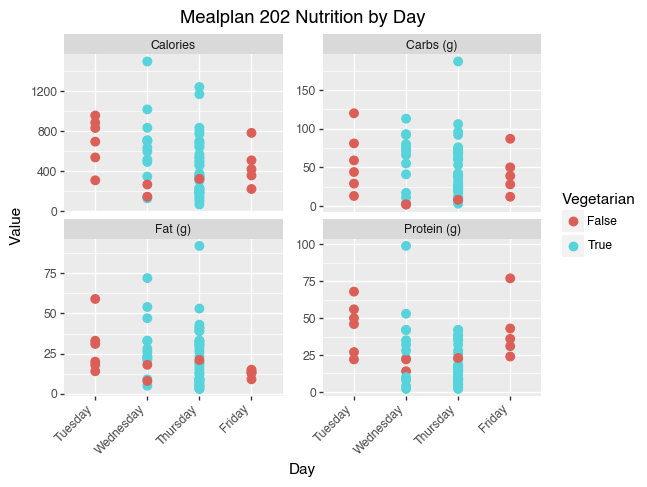

In [239]:
# Days order
df["Day of the Week"] = pd.Categorical(df["Day of the Week"],
categories=["Tuesday","Wednesday","Thursday","Friday"],
 ordered=True)

# Melt the data 
df_long = df.melt(
    id_vars=["Day of the Week", "Vegetarian"],
    value_vars=["Calories", "Protein (g)", "Fat (g)", "Carbs (g)"],
    var_name="Nutrient", value_name="Value"
).dropna(subset=["Value"])

# Plot
(
    ggplot(df_long, aes(x="Day of the Week", y="Value", color="Vegetarian"))
    + geom_point(size=3)
    + facet_wrap("~Nutrient", scales="free_y")
    + labs(title="Mealplan 202 Nutrition by Day", x="Day", y="Value")
    +theme(axis_text_x=element_text(rotation=45, ha="right"))
)
